In [1]:
import os
import torch
import math
import torch
import pandas as pd
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torch import optim
from tqdm import tqdm
import logging
from torch.utils.tensorboard import SummaryWriter

In [2]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")
def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

# Data Preprocessing

In [3]:
# Fred's encoder code
class DescreteEncoder:
    def __init__(self, duration: int = 1440, step_size: int = 10):
        self.duration = duration
        self.step_size = step_size
        self.steps = duration // step_size
        self.index_to_acts = {}
        self.acts_to_index = {}

    def encode(self, data: pd.DataFrame):
        # Create mappings from activity to index and vice versa
        self.index_to_acts = {i: a for i, a in enumerate(data.act.unique())}
        self.acts_to_index = {a: i for i, a in self.index_to_acts.items()}
        
        # Create a new DataFrame for encoded data
        encoded_data = data.copy()
        encoded_data['act'] = encoded_data['act'].map(self.acts_to_index)
        return encoded_data
    
    def decode(self, encoded_image_grid) -> pd.DataFrame:
        if isinstance(encoded_image_grid, torch.Tensor):
            encoded_image_grid = encoded_image_grid.numpy()
        
        decoded = []
        for pid in range(encoded_image_grid.shape[0]):
            sequence = encoded_image_grid[pid]
            current_act = None
            act_start = None
            
            for time_step, act_index in enumerate(sequence):
                # If the activity changes or it's the end of the day, record the activity
                if act_index != current_act and current_act is not None:
                    act_end = time_step * self.step_size
                    decoded.append({
                        "pid": pid,
                        "act": self.index_to_acts[current_act],
                        "start": act_start,
                        "end": act_end
                    })
                    act_start = time_step * self.step_size
                # If the activity changes, update the current activity
                if act_index != current_act:
                    current_act = act_index
                    act_start = time_step * self.step_size
            
            # Add the last activity of the day if the day ended with an activity
            if current_act is not None and act_start is not None:
                decoded.append({
                    "pid": pid,
                    "act": self.index_to_acts[current_act],
                    "start": act_start,
                    "end": self.duration
                })

        return pd.DataFrame(decoded, columns=["pid", "act", "start", "end"])

In [4]:
# Load data and encode it
data = pd.read_csv('./data/nts_toy_home_population.csv')
encoder = DescreteEncoder()
encoded_data = encoder.encode(data)

# Function to convert encoded data into an image grid
def create_image_grid(encoded_data, encoder):
    # Map pid to sequential indices starting from 0
    pid_to_index = {pid: index for index, pid in enumerate(encoded_data['pid'].unique())}
    
    num_people = len(pid_to_index)
    time_steps = encoder.steps
    grid = np.zeros((num_people, time_steps))
    
    for _, row in encoded_data.iterrows():
        pid_index = pid_to_index[row['pid']]
        act_index = row['act']
        start_step = row['start'] // encoder.step_size
        end_step = row['end'] // encoder.step_size
        grid[pid_index, start_step:end_step] = act_index
    
    return grid

image_grid = create_image_grid(encoded_data, encoder)
tensor_image_grid = torch.tensor(image_grid)
torch.save(tensor_image_grid, './data/image_grid.pt')

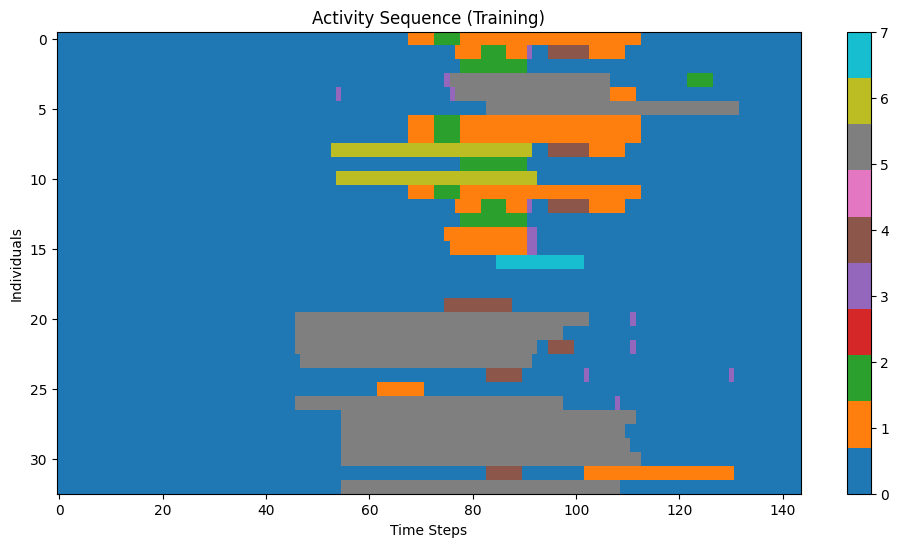

In [5]:
def plot_image_grid(image_grid, title = 'Activity Sequence (Training)' ):    
    plt.figure(figsize=(12, 6))
    plt.imshow(image_grid, aspect='auto', cmap="tab10")
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Individuals')
    plt.show()
plot_image_grid(image_grid)

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# Define constants
BATCH_SIZE = 8
NUM_ACTIVITIES = 8
EMBEDDING_DIM = 8
torch.manual_seed(42)

# Load the dataset
dataset_path = './data/image_grid.pt'
tensor_image_grid = torch.load(dataset_path)

# Ensure the dataset is divisible by the batch size
tensor_image_grid = tensor_image_grid[:-(tensor_image_grid.shape[0] % BATCH_SIZE)]

# Extract the number of sequences and sequence length
N, sequence_length = tensor_image_grid.shape
print("Tensor image grid shape:", tensor_image_grid.shape)

# Initialize the embedding layer
embedding_layer = nn.Embedding(NUM_ACTIVITIES, EMBEDDING_DIM)

# Convert the dataset to long type and flatten for embedding
tensor_image_grid = tensor_image_grid.long()

assert tensor_image_grid.max() < NUM_ACTIVITIES, "Activity index exceeds NUM_ACTIVITIES."
assert tensor_image_grid.min() >= 0, "Activity index is below 0."

flattened_tensor = tensor_image_grid.view(-1)

# Embed the dataset
embedded_tensor = embedding_layer(flattened_tensor)
embedded_tensor = embedded_tensor.view(N, sequence_length, EMBEDDING_DIM)
print("Embedded tensor shape:", embedded_tensor.shape)

mean = embedded_tensor.mean(dim=(0, 1), keepdim=True)
std = embedded_tensor.std(dim=(0, 1), keepdim=True) + 1e-9  # Adding epsilon to avoid division by zero
normalized_embedded_tensor = (embedded_tensor - mean) / std


# Create the DataLoader with normalized embeddings
normalized_dataset = TensorDataset(normalized_embedded_tensor)
dataloader = DataLoader(normalized_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Iterate over the normalized DataLoader and print the shapes and data for each batch
for i, (x,) in enumerate(dataloader):
    print(f"Normalized Batch {i} shape: {x.shape}")
    print(f"Normalized Batch {i} data:\n{x}")


Tensor image grid shape: torch.Size([32, 144])
Embedded tensor shape: torch.Size([32, 144, 8])
Normalized Batch 0 shape: torch.Size([8, 144, 8])
Normalized Batch 0 data:
tensor([[[ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         ...,
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919]],

        [[ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         ...,
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324,  0.3313,  0.5422,  ..., -0.4884,  0.4343, -0.4919],
         [ 0.5324, 

# Diffusion

In [7]:
class Diffusion:
    def __init__(self, noise_steps=25, beta_start=0.0001, beta_end=0.02, sequence_length=144, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.sequence_length = sequence_length
        self.device = device

        self.beta = self.schedule_noise().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def schedule_noise(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_embeddings(self, embeddings, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None]

        epsilon = torch.randn_like(embeddings)

        noisy_embeddings = sqrt_alpha_hat * embeddings + sqrt_one_minus_alpha_hat * epsilon

        # Debug: Check for NaNs
        if torch.isnan(noisy_embeddings).any():
            print("NaNs detected in noisy_embeddings")
            print("sqrt_alpha_hat:", sqrt_alpha_hat)
            print("sqrt_one_minus_alpha_hat:", sqrt_one_minus_alpha_hat)
            print("epsilon:", epsilon)

        return noisy_embeddings.float(), epsilon.float()

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, embedding_dim):
        logging.info(f"Sampling {n} new sequences...")
        model.eval()
        with torch.no_grad():
            # Initialise x with the proper dimensions for sequence data.
            x = torch.randn((n, self.sequence_length, embedding_dim)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                # Adjust dimensions for alpha, alpha_hat, and beta to match x
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]

                if i > 2:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise) + torch.sqrt(beta) * noise

        model.train()
        return x

In [8]:
diffusion = Diffusion(noise_steps=25, beta_start=0.0001, beta_end=0.02, sequence_length=144, device="cpu")

# Testing cell

diffusion = Diffusion(noise_steps=125, beta_start=0.0001, beta_end=0.02, sequence_length=144, device="cpu")

print("First few beta values:", diffusion.beta[:5])
print("First few alpha values:", diffusion.alpha[:5])
print("First few alpha_hat values:", diffusion.alpha_hat[:5])

for i, (x,) in enumerate(dataloader):
    if i == 0: 
        t = diffusion.sample_timesteps(x.size(0))
        noisy_embeddings, epsilon = diffusion.noise_embeddings(x, t)
        print("Original vs Noisy Embeddings:")
        print("Original shape:", x.shape, "| Noisy shape:", noisy_embeddings.shape)
        
        # Optional: Calculate the difference to see if noise was added
        difference = (noisy_embeddings - x).abs().mean()
        print("Mean absolute difference between original and noisy embeddings:", difference.item())
        break 

# Transformer

In [9]:
from models.transformer import TransformerWithPositionalEncoding

def setup_logging(run_name):
    logging.basicConfig(level=logging.INFO)

def train():
    run_name = "first_run"
    device = "cpu"
    learning_rate = 0.002
    epochs = 150

    setup_logging(run_name)
    model = TransformerWithPositionalEncoding().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse = nn.MSELoss() 
    diffusion = Diffusion(device=device)
    logger = SummaryWriter(os.path.join("runs", run_name))

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}")
        epoch_loss = 0.0
        for batch_idx, (x,) in enumerate(tqdm(dataloader)):
            embedded_x = x.to(device) 

            optimizer.zero_grad()  
            timesteps = torch.randint(0, diffusion.noise_steps, (embedded_x.size(0),), device=device)
            embedded_x = embedded_x.float()
            noisy_x, _ = diffusion.noise_embeddings(embedded_x, timesteps)
            predicted_x = model(noisy_x, timesteps)

            loss = mse(predicted_x, noisy_x)
            loss.backward(retain_graph=True)
            optimizer.step()  
            epoch_loss += loss.item()

            # Log training loss to TensorBoard every 10 batches
            if batch_idx % 10 == 0:
                logger.add_scalar("Loss/train", loss.item(), epoch * len(dataloader) + batch_idx)

        avg_epoch_loss = epoch_loss / len(dataloader)
        logging.info(f"Epoch {epoch} Average Loss: {avg_epoch_loss}")
        logger.add_scalar("Loss/epoch_avg_train", avg_epoch_loss, epoch)

    logger.close()

train()

11:29:54 - INFO: Starting epoch 0
100%|██████████| 4/4 [00:00<00:00, 11.67it/s]
11:29:55 - INFO: Epoch 0 Average Loss: 0.9756919890642166
11:29:55 - INFO: Starting epoch 1
100%|██████████| 4/4 [00:00<00:00, 12.60it/s]
11:29:55 - INFO: Epoch 1 Average Loss: 0.8691976070404053
11:29:55 - INFO: Starting epoch 2
100%|██████████| 4/4 [00:00<00:00, 12.84it/s]
11:29:55 - INFO: Epoch 2 Average Loss: 0.7962456792593002
11:29:55 - INFO: Starting epoch 3
100%|██████████| 4/4 [00:00<00:00, 12.27it/s]
11:29:56 - INFO: Epoch 3 Average Loss: 0.7509707361459732
11:29:56 - INFO: Starting epoch 4
100%|██████████| 4/4 [00:00<00:00, 12.24it/s]
11:29:56 - INFO: Epoch 4 Average Loss: 0.6910431683063507
11:29:56 - INFO: Starting epoch 5
100%|██████████| 4/4 [00:00<00:00, 12.76it/s]
11:29:56 - INFO: Epoch 5 Average Loss: 0.642876535654068
11:29:56 - INFO: Starting epoch 6
100%|██████████| 4/4 [00:00<00:00, 12.41it/s]
11:29:57 - INFO: Epoch 6 Average Loss: 0.602635845541954
11:29:57 - INFO: Starting epoch 7
10

In [15]:
def map_embeddings_to_activities(embedded_sequences, embedding_layer):
    # Get the embeddings from the embedding layer (shape: [NUM_ACTIVITIES, EMBEDDING_DIM])
    embeddings = embedding_layer.weight.data
    
    # Normalize embeddings to unit vectors
    embeddings = F.normalize(embeddings, p=2, dim=1)

    # Normalize each vector in the generated sequences to unit vectors
    embedded_sequences = embedded_sequences.view(-1, EMBEDDING_DIM)
    embedded_sequences = F.normalize(embedded_sequences, p=2, dim=1)

    # Calculate dot products (shape: [num_sequences * sequence_length, NUM_ACTIVITIES])
    dot_products = torch.matmul(embedded_sequences, embeddings.T)
    
    # The resulting indices are the activities (shape: [num_sequences * sequence_length])
    _, activities = torch.max(dot_products, dim=1)

    return activities.view(-1, sequence_length)  # Reshape back to original shape


In [16]:
# After generating new sequences using the diffusion model
Model = TransformerWithPositionalEncoding()
generated_sequences = diffusion.sample(model = Model, n=32, embedding_dim=8)

# Map the generated sequences back to discrete activities
discrete_activities = map_embeddings_to_activities(generated_sequences, embedding_layer)


11:31:26 - INFO: Sampling 32 new sequences...
24it [00:01, 23.36it/s]


In [17]:
# Decode each activity index back to its label
decoded_sequences = [[encoder.index_to_acts[index.item()] for index in sequence] for sequence in discrete_activities]


In [18]:
df_decoded = pd.DataFrame(decoded_sequences, columns=[f"Step {i}" for i in range(len(decoded_sequences[0]))])
df_decoded.head(5) 

,Step 0,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9,...,Step 134,Step 135,Step 136,Step 137,Step 138,Step 139,Step 140,Step 141,Step 142,Step 143
0,medical,education,escort,other,work,other,visit,education,escort,home,...,home,work,home,home,medical,visit,home,education,escort,home
1,escort,home,education,visit,medical,visit,shop,home,home,medical,...,other,home,home,shop,medical,shop,escort,shop,shop,work
2,home,medical,education,medical,shop,shop,home,other,escort,home,...,other,medical,home,escort,shop,other,shop,medical,home,shop
3,shop,education,work,home,home,other,other,shop,education,home,...,escort,visit,work,visit,visit,shop,home,education,visit,home
4,visit,shop,visit,home,shop,work,work,home,medical,work,...,shop,shop,other,escort,escort,other,home,visit,other,shop


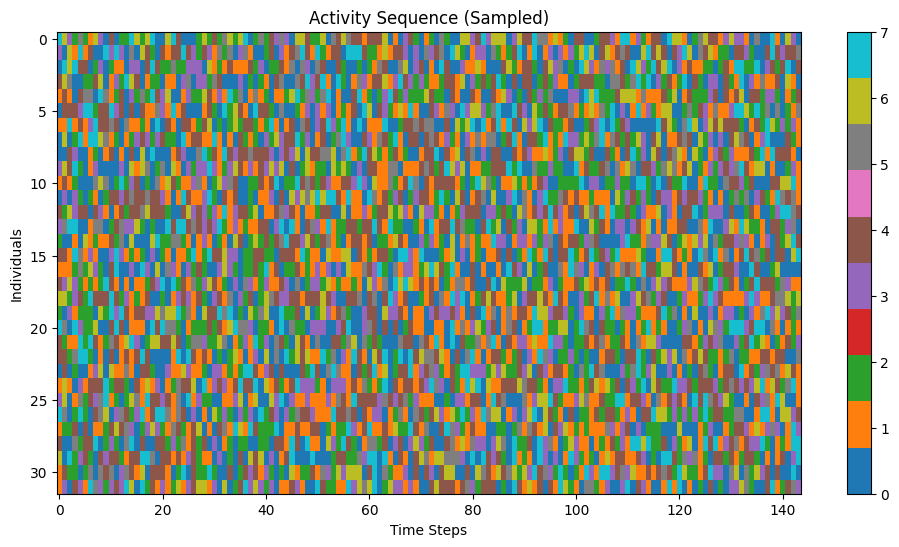

In [19]:
plot_image_grid(discrete_activities, title = 'Activity Sequence (Sampled)')